In [9]:
import os
import tomopy
import numpy as np
from imars3d.filters import tilt
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.prep.calculation as calc
import algotom.rec.reconstruction as rec
import bm3d_streak_removal as bm3d
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp
import svmbir
import ast

In [2]:
# %matplotlib notebook
%matplotlib inline

In [3]:
ncore = mp.cpu_count()
ncore

256

# Workflow starts here!

In [4]:
###################### need to change start
ipts="30634"
###################### need to change end

In [5]:
hdf5_loc = "/netdisk/y9z/IPTS-"+ipts+"/hdf5/"
# hdf5_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
os.listdir(hdf5_loc)

['2023_06_01_tube1_cropped.h5']

In [6]:
###################### need to change start
sample_name = "2023_06_01_tube1_cropped"
hdf5 = hdf5_loc + sample_name + ".h5"
###################### need to change end

# Load hdf5 file

In [7]:
losa.get_hdf_tree(hdf5)

 tomo
    │
    ├── info
    │   │
    │   ├── ang_deg (538,)
    │   ├── ang_rad (538,)
    │   ├── fname (538,)
    │   ├── proj000_idx (1,)
    │   └── proj180_idx (1,)
    ├── proj
    │   │
    │   ├── dc_fake (6400, 936)
    │   ├── ob_fake (6400, 936)
    │   ├── proj_mlog_to_recon (538, 6400, 936)
    │   └── proj_norm (538, 6400, 936)
    ├── raw_ref
    │   │
    │   ├── dc_max (6400, 936)
    │   ├── fluc_corr_roi_min (5980, 195)
    │   ├── ob_min (6400, 936)
    │   ├── proj_crop_roi_min (6400, 936)
    │   └── proj_min (6400, 936)
    ├── recon
    │   │
    │   ├── history (1,)
    │   ├── recon_unit (1,)
    │   └── recon_volume (6400, 400, 370)
    └── sino
        │
        ├── sino_mlog_to_recon (6400, 538, 936)
        └── sino_norm (6400, 538, 936)


deque([' tomo',
       '    │',
       '    ├── info',
       '    │   │',
       '    │   ├── ang_deg (538,)',
       '    │   ├── ang_rad (538,)',
       '    │   ├── fname (538,)',
       '    │   ├── proj000_idx (1,)',
       '    │   └── proj180_idx (1,)',
       '    ├── proj',
       '    │   │',
       '    │   ├── dc_fake (6400, 936)',
       '    │   ├── ob_fake (6400, 936)',
       '    │   ├── proj_mlog_to_recon (538, 6400, 936)',
       '    │   └── proj_norm (538, 6400, 936)',
       '    ├── raw_ref',
       '    │   │',
       '    │   ├── dc_max (6400, 936)',
       '    │   ├── fluc_corr_roi_min (5980, 195)',
       '    │   ├── ob_min (6400, 936)',
       '    │   ├── proj_crop_roi_min (6400, 936)',
       '    │   └── proj_min (6400, 936)',
       '    ├── recon',
       '    │   │',
       '    │   ├── history (1,)',
       '    │   ├── recon_unit (1,)',
       '    │   └── recon_volume (6400, 400, 370)',
       '    └── sino',
       '        │',
       '        ├

In [10]:
history_dict_str = losa.load_hdf(hdf5, key_path='tomo/recon/history')[0]
history_dict = ast.literal_eval(history_dict_str.decode("utf-8"))
proj_mlog = losa.load_hdf(hdf5, key_path='tomo/proj/proj_mlog_to_recon')
ang_rad = losa.load_hdf(hdf5, key_path='tomo/info/ang_rad')
proj000_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj000_idx')[0]
proj180_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj180_idx')[0]
rot_center = history_dict['rot_center']
recon_hdf5 = losa.load_hdf(hdf5, key_path='tomo/recon/recon_volume')
gamma_diff = 20
# sino_mlog_to_recon = np.moveaxis(proj_mlog_to_recon, 1, 0)
if 'recon_crop_roi' in history_dict.keys():
    recon_crop = True
    recon_crop_left = history_dict['recon_crop_roi']['left']
    recon_crop_right = history_dict['recon_crop_roi']['right']
    recon_crop_top = history_dict['recon_crop_roi']['top']
    recon_crop_bottom = history_dict['recon_crop_roi']['bottom']
else:
    recon_crop = False
    recon_crop_left = None
    recon_crop_right = None
    recon_crop_top = None
    recon_crop_bottom = None
history_dict

{'crop': False,
 'gamma_filter': True,
 'normalization': True,
 'beam_fluc_corr': True,
 'beam_fluc_corr_roi': {'left': 5, 'right': 200, 'top': 20, 'bottom': 6000},
 'minus_log': True,
 'tilt_corr_roi': {'left': 0, 'right': 1500, 'top': 600, 'bottom': 5500},
 'tilt_corr': -0.33352298981903045,
 'ring_removal': 'bm3d',
 'rot_center': 500.8601608276367,
 'pixel_size_um': 7.63,
 'recon_algo': 'gridrec',
 'recon_crop': True,
 'recon_crop_roi': {'left': 280, 'right': 650, 'top': 250, 'bottom': 650}}

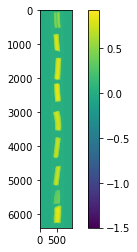

In [14]:
###################### need to change start
idx = 0
###################### need to change end
plt.imshow(proj_mlog[idx])
plt.colorbar()
plt.show()

In [13]:
proj_mlog = tomopy.misc.corr.remove_outlier(proj_mlog, gamma_diff, ncore=ncore)

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

Tilt correction ROI at 0 degree:


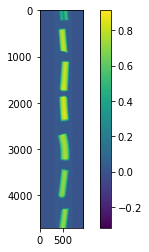

Tilt correction ROI at 180 degree (flipped):


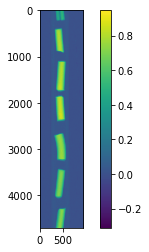

In [16]:
###################### need to change start
tt_left = 0
tt_right = 1500
tt_top = 300
tt_bottom = 5000
###################### need to change start
tt_roi_dict = {
    'left': tt_left,
    'right': tt_right,
    'top': tt_top,
    'bottom': tt_bottom
}
tt_000deg_mlog = proj_mlog[proj000_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_180deg_mlog = proj_mlog[proj180_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
print("Tilt correction ROI at 0 degree:")
# plt.imshow(tt_000deg_trans)
# plt.colorbar()
# plt.show()
plt.imshow(tt_000deg_mlog)
plt.colorbar()
plt.show()
print("Tilt correction ROI at 180 degree (flipped):")
# plt.imshow(tt_180deg_trans)
# plt.colorbar()
# plt.show()
plt.imshow(np.fliplr(tt_180deg_mlog))
plt.colorbar()
plt.show()

In [17]:
print("Finding the tilt angle using minus log images...")
t0 = timeit.default_timer()
tilt_ang = tilt.calculate_tilt(image0=tt_000deg_mlog, image180=tt_180deg_mlog)
print("Found the tilt angle: ", tilt_ang.x)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Finding the tilt angle using minus log images...
Found the tilt angle:  -0.07857945178456427
Time: 26.44395697955042 s


In [18]:
t0 = timeit.default_timer()
# tilt_ang.x = -0.7256422310429781
proj_mlog_tilt = proj_mlog[:]
for e_idx in range(proj_mlog.shape[0]):
    proj_mlog_tilt[e_idx] = tilt.apply_tilt_correction(proj_mlog[e_idx], tilt_ang.x, ncore=ncore)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))

Time cost 0.9688007811627661 min


In [19]:
sino_mlog_to_recon = np.moveaxis(proj_mlog_tilt, 1, 0)

In [20]:
# Use Vo's approach for 360 sinogram (180sinogram is calc.find_center_vo)
rot_center = calc.find_center_360(sino_mlog_to_recon[int(sino_mlog_to_recon.shape[0]/2)], win_width=800)[0]
print('Estimated center of rotation:', rot_center)
history_dict = rocku.log(history_dict, 'rot_center', rot_center)

Estimated center of rotation: 500.8615493774414


Center of rotation 500.8615493774414
Time cost 0.002282176484974722 min


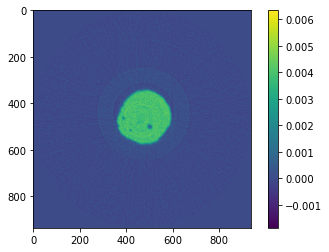

In [37]:
slice_idx = 6100
print("Center of rotation", rot_center)
t0 = timeit.default_timer()
rec_img1 = rec.gridrec_reconstruction(sino_mlog_to_recon[slice_idx], rot_center, angles=ang_rad, apply_log=False,
                                      ratio=1.0,
                                      filter_name='shepp',
                                      pad=100,
                                      ncore=ncore
                                     )
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
plt.imshow(rec_img1)
plt.colorbar()
plt.show()

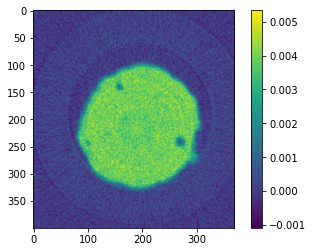

In [43]:
###################### need to change start
idx = 6200
###################### need to change end
rec_img = rec.gridrec_reconstruction(sino_mlog_to_recon[idx], rot_center, angles=ang_rad, apply_log=False)
rec_img = rocku.crop(rec_img, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
plt.imshow(rec_img)
plt.colorbar()
plt.show()

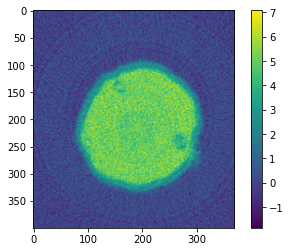

In [44]:
plt.imshow(recon_hdf5[idx])
plt.colorbar()
plt.show()

# Reconstruction

In [46]:
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name + "_redo"
save_to = "/netdisk/y9z/IPTS-"+ipts+"/recon/" + sample_name + "_redo"
pix_um = history_dict['pixel_size_um']
pix_cm = pix_um/10000
t0 = timeit.default_timer()
recon_algo = 'gridrec'
for h_idx in range(sino_mlog_to_recon.shape[0]):
    _rec_slice = rec.gridrec_reconstruction(sino_mlog_to_recon[h_idx], rot_center, angles=ang_rad, apply_log=False)
    _rec_slice = rocku.crop(_rec_slice, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
    _rec_slice_cm = _rec_slice/pix_cm
    _slice_name = save_to + "/recon_" + f'{h_idx:04d}'
    print('Saving {} ...'.format(_slice_name))
    dxchange.write_tiff(_rec_slice_cm, fname=_slice_name, overwrite=True)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
# history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0000 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0001 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0002 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0003 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0004 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0005 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0006 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0007 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0008 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0009 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0010 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0011 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0100 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0101 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0102 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0103 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0104 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0105 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0106 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0107 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0108 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0109 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0110 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0111 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0200 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0201 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0202 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0203 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0204 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0205 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0206 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0207 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0208 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0209 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0210 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0211 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0301 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0302 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0303 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0304 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0305 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0306 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0307 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0308 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0309 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0310 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0311 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0312 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0402 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0403 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0404 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0405 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0406 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0407 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0408 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0409 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0410 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0411 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0412 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0413 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0502 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0503 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0504 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0505 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0506 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0507 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0508 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0509 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0510 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0511 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0512 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0513 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0602 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0603 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0604 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0605 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0606 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0607 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0608 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0609 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0610 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0611 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0612 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0613 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0702 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0703 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0704 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0705 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0706 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0707 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0708 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0709 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0710 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0711 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0712 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0713 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0802 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0803 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0804 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0805 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0806 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0807 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0808 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0809 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0810 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0811 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0812 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0813 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0902 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0903 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0904 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0905 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0906 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0907 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0908 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0909 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0910 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0911 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0912 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_0913 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1003 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1004 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1005 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1006 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1007 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1008 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1009 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1010 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1011 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1012 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1013 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1014 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1103 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1104 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1105 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1106 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1107 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1108 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1109 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1110 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1111 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1112 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1113 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1114 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1204 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1205 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1206 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1207 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1208 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1209 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1210 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1211 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1212 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1213 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1214 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1215 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1304 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1305 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1306 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1307 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1308 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1309 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1310 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1311 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1312 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1313 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1314 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1315 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1404 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1405 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1406 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1407 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1408 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1409 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1410 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1411 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1412 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1413 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1414 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1415 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1504 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1505 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1506 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1507 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1508 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1509 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1510 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1511 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1512 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1513 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1514 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1515 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1604 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1605 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1606 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1607 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1608 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1609 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1610 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1611 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1612 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1613 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1614 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1615 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1705 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1706 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1707 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1708 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1709 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1710 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1711 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1712 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1713 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1714 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1715 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1716 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1805 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1806 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1807 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1808 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1809 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1810 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1811 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1812 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1813 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1814 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1815 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1816 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1905 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1906 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1907 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1908 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1909 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1910 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1911 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1912 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1913 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1914 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1915 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_1916 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2006 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2007 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2008 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2009 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2010 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2011 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2012 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2013 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2014 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2015 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2016 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2017 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2106 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2107 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2108 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2109 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2110 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2111 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2112 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2113 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2114 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2115 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2116 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2117 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2206 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2207 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2208 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2209 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2210 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2211 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2212 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2213 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2214 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2215 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2216 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2217 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2306 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2307 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2308 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2309 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2310 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2311 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2312 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2313 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2314 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2315 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2316 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2317 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2406 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2407 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2408 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2409 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2410 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2411 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2412 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2413 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2414 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2415 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2416 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2417 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2507 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2508 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2509 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2510 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2511 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2512 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2513 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2514 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2515 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2516 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2517 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2518 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2607 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2608 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2609 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2610 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2611 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2612 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2613 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2614 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2615 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2616 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2617 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2618 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2707 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2708 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2709 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2710 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2711 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2712 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2713 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2714 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2715 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2716 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2717 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2718 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2807 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2808 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2809 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2810 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2811 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2812 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2813 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2814 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2815 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2816 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2817 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2818 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2908 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2909 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2910 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2911 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2912 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2913 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2914 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2915 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2916 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2917 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2918 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_2919 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3008 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3009 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3010 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3011 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3012 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3013 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3014 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3015 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3016 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3017 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3018 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3019 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3108 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3109 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3110 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3111 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3112 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3113 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3114 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3115 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3116 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3117 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3118 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3119 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3208 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3209 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3210 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3211 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3212 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3213 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3214 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3215 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3216 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3217 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3218 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3219 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3309 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3310 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3311 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3312 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3313 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3314 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3315 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3316 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3317 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3318 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3319 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3320 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3409 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3410 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3411 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3412 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3413 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3414 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3415 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3416 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3417 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3418 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3419 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3420 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3509 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3510 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3511 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3512 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3513 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3514 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3515 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3516 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3517 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3518 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3519 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3520 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3609 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3610 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3611 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3612 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3613 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3614 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3615 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3616 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3617 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3618 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3619 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3620 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3709 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3710 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3711 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3712 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3713 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3714 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3715 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3716 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3717 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3718 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3719 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3720 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3809 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3810 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3811 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3812 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3813 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3814 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3815 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3816 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3817 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3818 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3819 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3820 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3910 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3911 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3912 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3913 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3914 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3915 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3916 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3917 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3918 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3919 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3920 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_3921 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4010 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4011 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4012 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4013 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4014 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4015 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4016 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4017 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4018 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4019 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4020 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4021 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4110 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4111 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4112 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4113 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4114 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4115 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4116 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4117 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4118 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4119 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4120 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4121 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4210 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4211 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4212 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4213 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4214 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4215 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4216 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4217 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4218 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4219 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4220 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4221 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4310 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4311 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4312 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4313 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4314 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4315 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4316 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4317 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4318 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4319 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4320 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4321 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4410 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4411 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4412 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4413 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4414 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4415 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4416 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4417 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4418 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4419 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4420 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4421 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4510 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4511 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4512 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4513 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4514 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4515 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4516 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4517 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4518 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4519 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4520 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4521 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4610 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4611 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4612 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4613 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4614 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4615 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4616 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4617 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4618 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4619 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4620 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4621 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4710 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4711 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4712 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4713 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4714 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4715 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4716 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4717 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4718 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4719 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4720 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4721 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4810 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4811 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4812 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4813 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4814 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4815 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4816 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4817 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4818 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4819 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4820 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4821 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4910 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4911 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4912 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4913 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4914 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4915 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4916 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4917 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4918 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4919 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4920 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_4921 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5010 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5011 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5012 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5013 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5014 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5015 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5016 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5017 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5018 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5019 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5020 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5021 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5110 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5111 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5112 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5113 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5114 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5115 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5116 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5117 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5118 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5119 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5120 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5121 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5210 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5211 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5212 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5213 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5214 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5215 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5216 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5217 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5218 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5219 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5220 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5221 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5310 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5311 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5312 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5313 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5314 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5315 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5316 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5317 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5318 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5319 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5320 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5321 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5410 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5411 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5412 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5413 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5414 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5415 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5416 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5417 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5418 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5419 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5420 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5421 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5510 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5511 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5512 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5513 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5514 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5515 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5516 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5517 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5518 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5519 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5520 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5521 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5610 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5611 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5612 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5613 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5614 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5615 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5616 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5617 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5618 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5619 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5620 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5621 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5710 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5711 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5712 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5713 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5714 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5715 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5716 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5717 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5718 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5719 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5720 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5721 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5810 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5811 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5812 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5813 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5814 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5815 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5816 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5817 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5818 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5819 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5820 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5821 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5910 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5911 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5912 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5913 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5914 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5915 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5916 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5917 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5918 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5919 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5920 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_5921 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6010 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6011 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6012 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6013 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6014 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6015 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6016 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6017 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6018 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6019 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6020 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6021 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6110 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6111 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6112 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6113 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6114 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6115 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6116 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6117 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6118 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6119 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6120 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6121 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6210 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6211 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6212 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6213 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6214 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6215 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6216 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6217 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6218 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6219 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6220 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6221 ...
Saving /netdisk/

Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6310 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6311 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6312 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6313 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6314 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6315 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6316 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6317 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6318 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6319 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6320 ...
Saving /netdisk/y9z/IPTS-30634/recon/2023_06_01_tube1_cropped_redo/recon_6321 ...
Saving /netdisk/